In [39]:
import pandas as pd
import numpy as np
fname_collected_RSSI = 'iBeacon_RSSI_Labeled.csv'

rssi_dataset_df = pd.read_csv(fname_collected_RSSI)
rssi_dataset_df.rename(columns={'b3004':'rssi'}, inplace=True)
# drop dup rows
rssi_dataset_df.drop_duplicates(subset=['location'],inplace=True)
# drop unknown row value
rssi_dataset_df = rssi_dataset_df[rssi_dataset_df.rssi != -200]

# select iBeacon 4 for generating radio map
rssi_dataset_df = rssi_dataset_df[['location','rssi']]
rssi_dataset_df.sort_values(by=['location'],inplace=True)
rssi_dataset_df

,location,rssi
239,O05,-80
81,P03,-73
251,P05,-76
302,P06,-80
1342,Q01,-78
1338,Q02,-73
87,Q03,-77
8,R01,-75
13,R02,-78
96,R03,-77


## Convert raw data from table to matrix

In [40]:
# create 2 cols as 2 matrix dimensions
rssi_dataset_df['col'] = rssi_dataset_df['location'].str[:1]
rssi_dataset_df['col'] = rssi_dataset_df['col'].apply(lambda alphabet_char: ord(alphabet_char)-ord('A'))
rssi_dataset_df['row'] = pd.to_numeric(rssi_dataset_df['location'].str[1:3])
rssi_dataset_df['row'] = rssi_dataset_df['row'].apply(lambda val: val-1)
# convert col from character to number
rssi_dataset_df

,location,rssi,col,row
239,O05,-80,14,4
81,P03,-73,15,2
251,P05,-76,15,4
302,P06,-80,15,5
1342,Q01,-78,16,0
1338,Q02,-73,16,1
87,Q03,-77,16,2
8,R01,-75,17,0
13,R02,-78,17,1
96,R03,-77,17,2


## Split train set & test set

In [41]:
training_data = rssi_dataset_df.sample(frac=0.8, random_state=25)
testing_data = rssi_dataset_df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 21
No. of testing examples: 5


In [42]:
# init a matrix with 20*23 size
n_rows = 20
n_cols = 23
# init value: set -200 as out of range value
OUT_OF_RANGE_RSSI = -200
radiomap_mtx = np.full((n_rows, n_cols), OUT_OF_RANGE_RSSI)
radiomap_mtx[training_data.row, training_data.col] = training_data.rssi
# init test matrix
radiomap_test = np.full((n_rows, n_cols), OUT_OF_RANGE_RSSI)
radiomap_test[testing_data.row, testing_data.col] = testing_data.rssi


# Matrix Factorization


In [43]:
from matrix_factorization import Matrix_Factorization

In [47]:
d = radiomap_mtx
d_test = radiomap_test
# d = np.array([[5,0,1],[3,1,0],[0,5,1]])
d2 = Matrix_Factorization(data=d, data_test=d_test, features=8, invalid_val=-200)
d2.train_model(learning_rate=0.01,iterations=1000)

RMSE in iter 50:  0.09407703082801605
RMSE test in iter 50:  44.416316603030864
RMSE in iter 100:  0.0010426715475589754
RMSE test in iter 100:  44.430133063276415
RMSE in iter 150:  2.4418736624321347e-05
RMSE test in iter 150:  44.43039139250822
RMSE in iter 200:  6.554533980958743e-07
RMSE test in iter 200:  44.43039806778541
RMSE in iter 250:  1.7905008492315024e-08
RMSE test in iter 250:  44.43039824798549
RMSE in iter 300:  4.904859798986101e-10
RMSE test in iter 300:  44.43039825290165
RMSE in iter 350:  1.3439607340468684e-11
RMSE test in iter 350:  44.430398253036195
RMSE in iter 400:  3.7111831424001014e-13
RMSE test in iter 400:  44.43039825303983
RMSE in iter 450:  4.713207304057789e-14
RMSE test in iter 450:  44.43039825303994
RMSE in iter 500:  4.4938668397781776e-14
RMSE test in iter 500:  44.43039825303994
RMSE in iter 550:  4.4938668397781776e-14
RMSE test in iter 550:  44.43039825303994
RMSE in iter 600:  4.4938668397781776e-14
RMSE test in iter 600:  44.4303982530399

# PLOT HEATMAP

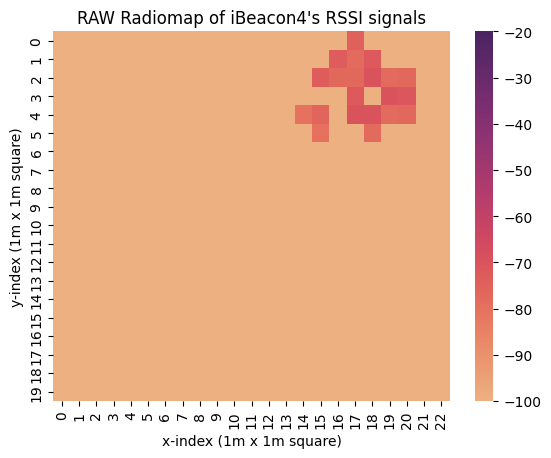

In [48]:
import seaborn as sns
import matplotlib.pylab as plt
sns.color_palette("flare", as_cmap=True)
ax = sns.heatmap(radiomap_mtx, cmap="flare",  vmin=-100, vmax=-20)
plt.title("RAW Radiomap of iBeacon4's RSSI signals")
plt.xlabel('x-index (1m x 1m square)', fontsize = 10) 
plt.ylabel('y-index (1m x 1m square)', fontsize = 10)
plt.show()

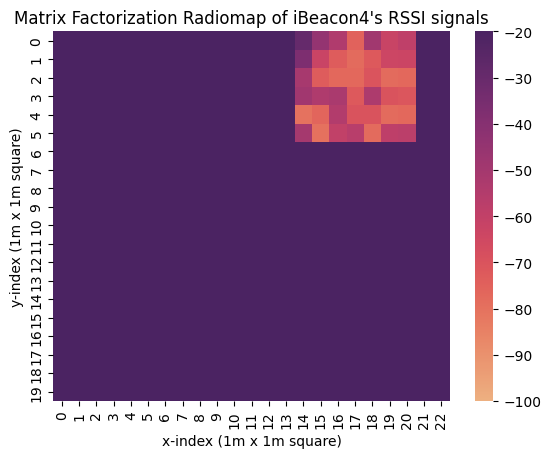

In [49]:
radiomap_mf = np.dot(d2.user_features,d2.item_features)
radiomap_mf.shape

sns.color_palette("flare", as_cmap=True)
ax = sns.heatmap(radiomap_mf, cmap="flare",  vmin=-100, vmax=-20)
plt.title("Matrix Factorization Radiomap of iBeacon4's RSSI signals")
plt.xlabel('x-index (1m x 1m square)', fontsize = 10) 
plt.ylabel('y-index (1m x 1m square)', fontsize = 10)
plt.show()